# Installing and Importing the Necessary Libraries

In [1]:
!pip install fitter
!pip install skrebate

In [2]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter
from skrebate import ReliefF
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import chi2_contingency
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

# Exploratory Data Analysis

**Important Assumption Throughout the Analysis**:

1. "age" column is treated as numerical, the remaining columns (shape, margin, density, severity) columns are treated as categorical - i.e., nominal.

In [3]:
# Create the mammography DataFrame and turn "?" into actual "NaN" values.
df_mammo = pd.read_excel("Mammography Data.xlsx")
for col in df_mammo.columns:
  df_mammo[col] = pd.to_numeric(df_mammo[col], errors='coerce')
df_mammo

age  shape  margin  density  severity
0    67.0    3.0     5.0      3.0         1
1    43.0    1.0     1.0      NaN         1
2    58.0    4.0     5.0      3.0         1
3    28.0    1.0     1.0      3.0         0
4    74.0    1.0     5.0      NaN         1
..    ...    ...     ...      ...       ...
956  47.0    2.0     1.0      3.0         0
957  56.0    4.0     5.0      3.0         1
958  64.0    4.0     5.0      3.0         0
959  66.0    4.0     5.0      3.0         1
960  62.0    3.0     3.0      3.0         0

[961 rows x 5 columns]

In [4]:
# Descriptive Statistics of the numerical column "Age":
df_mammo["age"].describe()

count    956.000000
mean      55.487448
std       14.480131
min       18.000000
25%       45.000000
50%       57.000000
75%       66.000000
max       96.000000
Name: age, dtype: float64

In [5]:
# Descriptive Statistics of the categorical columns:
# Since we cannot find mean, median, percentiles etc.
# of the categorical columns, I will be using value
# counts as the descriptive analysis of the categorical
# columns.

for col in df_mammo.drop("age", axis=1):
  display(df_mammo[col].value_counts())

shape
4.0    400
1.0    224
2.0    211
3.0     95
Name: count, dtype: int64

margin
1.0    357
4.0    280
5.0    136
3.0    116
2.0     24
Name: count, dtype: int64

density
3.0    798
2.0     59
1.0     16
4.0     12
Name: count, dtype: int64

severity
0    516
1    445
Name: count, dtype: int64

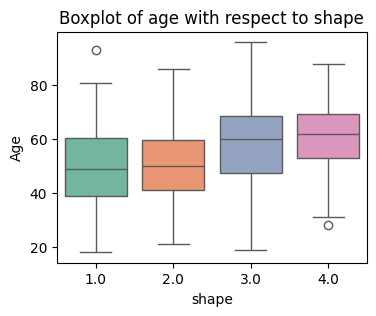

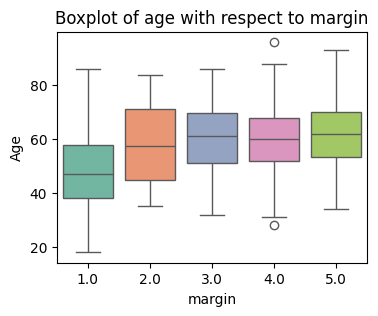

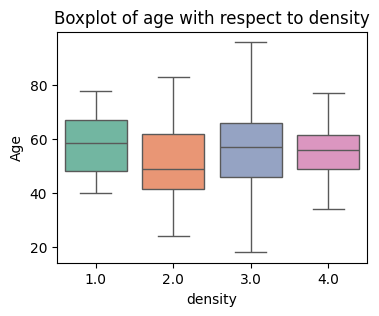

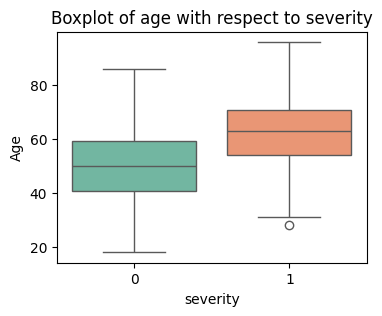

In [6]:
# Boxplots of the data:
# Again, since we cannot find mean, median, percentiles etc.
# of the categorical columns, we can only utilize it to see
# the distribution of the quantitative data across categories.

for col in df_mammo.drop("age", axis=1).columns:
  plt.figure(figsize=(4, 3))
  sns.boxplot(x=col, y="age", data=df_mammo, palette="Set2", hue=col)
  plt.title("Boxplot of age with respect to " + col)
  plt.xlabel(col)
  plt.ylabel("Age")
  plt.legend([],[], frameon=False)
  plt.show()
  print()

**Especially from the "Boxplot of age with respect to severity", it seems like as the age increases the probability of malignant tumor increases. However, this hypothesis requires more analysis - e.g.: T-Test or ANOVA would make quite sense here. However, it is out of scope for our assignment.**

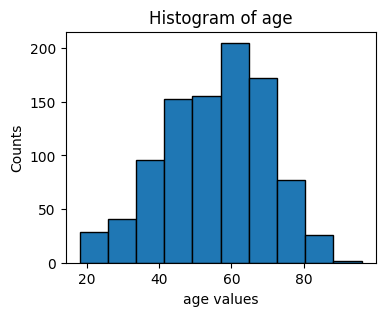

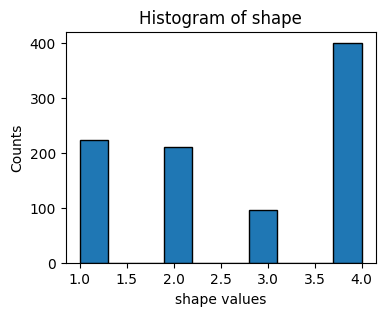

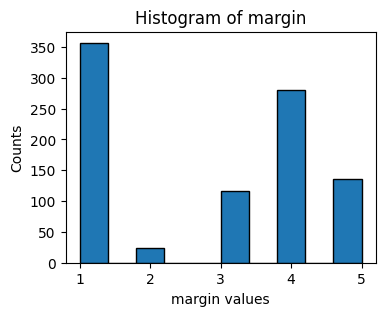

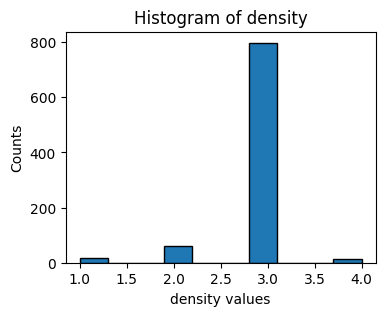

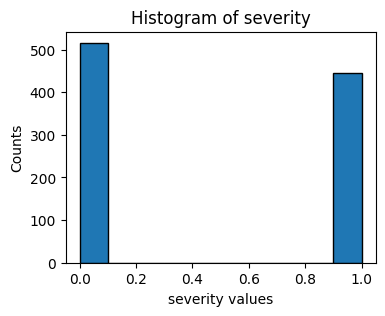

In [7]:
# Histogram of the data:

for col in df_mammo.columns:
  plt.figure(figsize=(4, 3))
  plt.hist(df_mammo[col], bins=10, edgecolor="k")
  plt.title("Histogram of " + col)
  plt.xlabel(col + " values")
  plt.ylabel("Counts")
  plt.show()
  print()

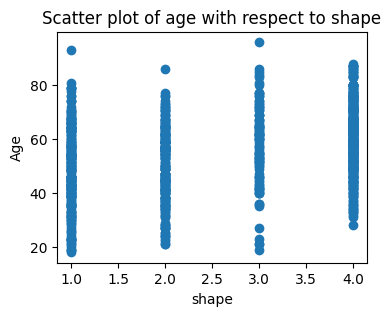

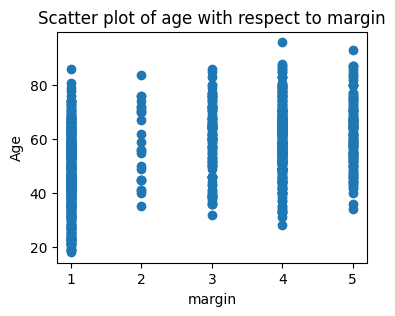

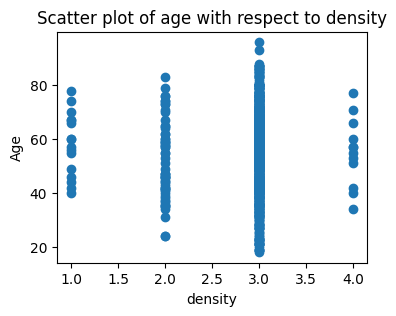

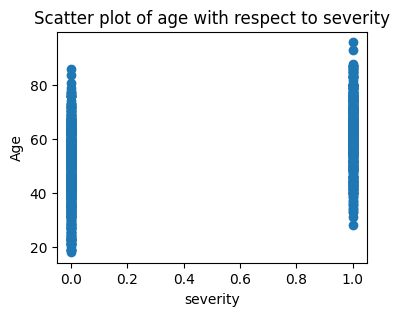

In [8]:
# Scatter plot: Similar to box-plot, it will not make sense between
# categorical columns. However, the categorical columns can be utilized
# to see the relationship of the categories with respect to a quantitative
# column.

for col in df_mammo.drop("age", axis=1).columns:
  plt.figure(figsize=(4, 3))
  plt.scatter(df_mammo[col], df_mammo['age'])
  plt.title("Scatter plot of age with respect to " + col)
  plt.xlabel(col)
  plt.ylabel("Age")
  plt.legend([],[], frameon=False)
  plt.show()
  print()

**By looking solely to the scatter plots, it is not really possible to mention any clear patterns. I can only mention that the age with respect to density has a clear group-to-group variance - i.e., we may not assume equal variances.**

Statistically, there is a correlation between shape and margin.



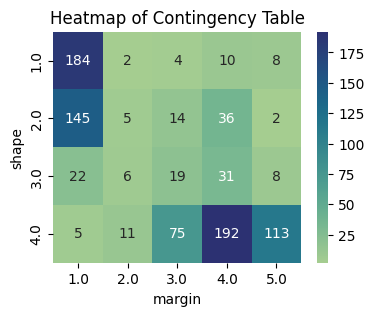


------------------

Statistically, there is a correlation between shape and density.



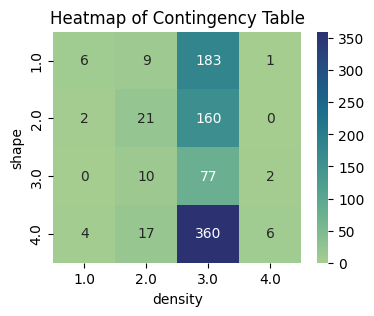


------------------

Statistically, there is a correlation between shape and severity.



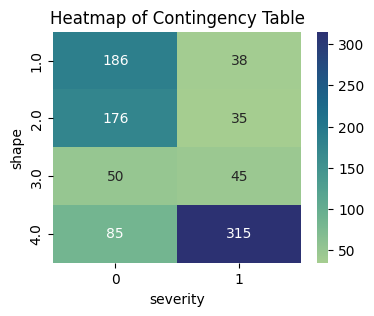


------------------

Statistically, there is no correlation between margin and density



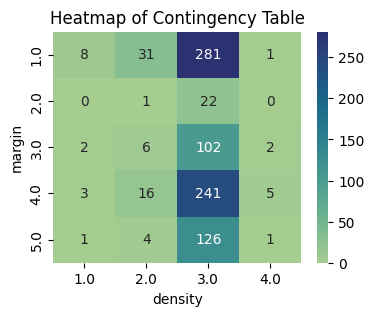


------------------

Statistically, there is a correlation between margin and severity.



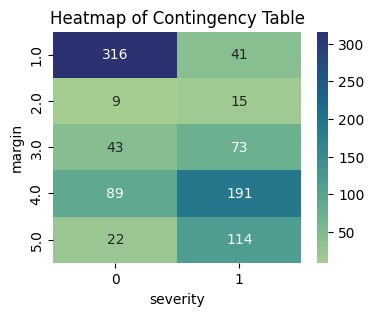


------------------

Statistically, there is a correlation between density and severity.



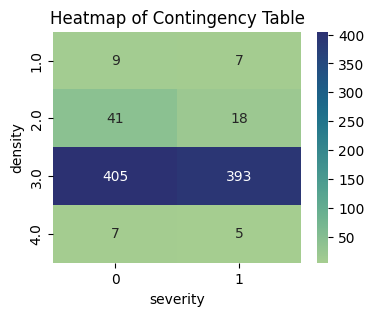


------------------



In [9]:
# To see the relationship between categorical variables, we may utilize
# chi-square contingency tables:

for comb in list(combinations(df_mammo.drop("age", axis=1).columns, 2)):
  plt.figure(figsize=(4, 3))
  contingency_table = pd.crosstab(df_mammo[comb[0]], df_mammo[comb[1]])
  chi2, p, dof, expected = chi2_contingency(contingency_table)
  if p < 0.05:
    print("Statistically, there is a correlation between ",
          comb[0], " and ", comb[1], ".", sep="")
  else:
    print("Statistically, there is no correlation between ",
          comb[0], " and ", comb[1], "", sep="")
  print()
  sns.heatmap(contingency_table, annot=True, fmt="d", cmap="crest")
  plt.title("Heatmap of Contingency Table")
  plt.show()
  print("\n------------------\n")

**It is shown that - except for the margin and density pair - the categorical variables are correlated with each other.**

**Summary**: There is a high probability that the "age" feature and "severity" target variable is correlated. In addition to that, except for the margin and density pair - the categorical variables are correlated with each other. It also shows us that each of the categorical variable has correlation with the target variable "severity".

# Data Preparation: Handling Missing Values

In [10]:
# First, I will check if we lose so many data points or not if we simply drop
# all rows with any missing values:
lostDataPointRatio = round((1 - (len(df_mammo.dropna()) / len(df_mammo))) * 100)
print("We lose " + str(lostDataPointRatio) + "% of the data points.")

We lose 14% of the data points.


It seems like we lose approximately 14% of the data. That does not seem like a big deal but let's see if the class weights change if we drop these rows.

In [11]:
# Let's see the initial unique values for each nominal column:
for col in df_mammo.columns:
  if col != "age":
    display(df_mammo[col].value_counts())

shape
4.0    400
1.0    224
2.0    211
3.0     95
Name: count, dtype: int64

margin
1.0    357
4.0    280
5.0    136
3.0    116
2.0     24
Name: count, dtype: int64

density
3.0    798
2.0     59
1.0     16
4.0     12
Name: count, dtype: int64

severity
0    516
1    445
Name: count, dtype: int64

In [12]:
# Now let's check if we lose any information if we drop all rows with nAn
# values:
for col in df_mammo.columns:
  if col != "age":
    display(df_mammo.dropna()[col].value_counts())

shape
4.0    380
1.0    190
2.0    180
3.0     81
Name: count, dtype: int64

margin
1.0    320
4.0    255
5.0    127
3.0    106
2.0     23
Name: count, dtype: int64

density
3.0    756
2.0     56
1.0     11
4.0      8
Name: count, dtype: int64

severity
0    428
1    403
Name: count, dtype: int64

Comparing the class weights of the initial state of the dataframe and the dropNA state of the dataframe, it seems like we did not lose any information based on class weights. On top of that, it seems like we lost only a small proportion of the data (i.e., 14%).

**What we have skipped initially is, the nature of the "age" column. Let's see how does this dropping case affects this column.**

sumsquare_error         aic         bic  kl_div  ks_statistic  \
skewnorm         0.000160  200.017705  214.605979     inf      0.039088   
norm             0.000205  196.156517  205.882033     inf      0.045802   

          ks_pvalue  
skewnorm   0.104913  
norm       0.035103

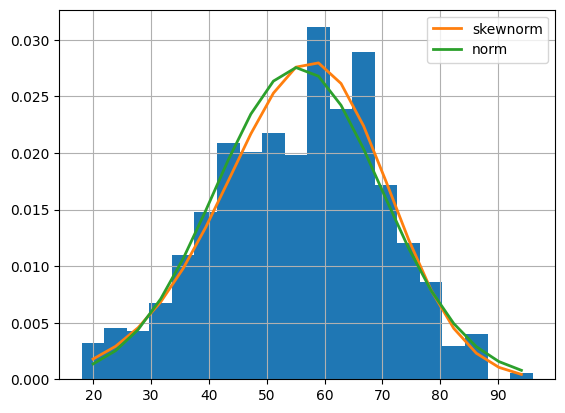

In [13]:
# Initial state of the age column:
f = Fitter(df_mammo["age"].dropna(), distributions=["skewnorm", "norm"],
           bins=20)
f.fit()
f.summary()

sumsquare_error         aic         bic  kl_div  ks_statistic  \
skewnorm         0.000139  199.108967  213.276857     inf      0.037492   
norm             0.000184  195.384590  204.829849     inf      0.044706   

          ks_pvalue  
skewnorm   0.188436  
norm       0.070012

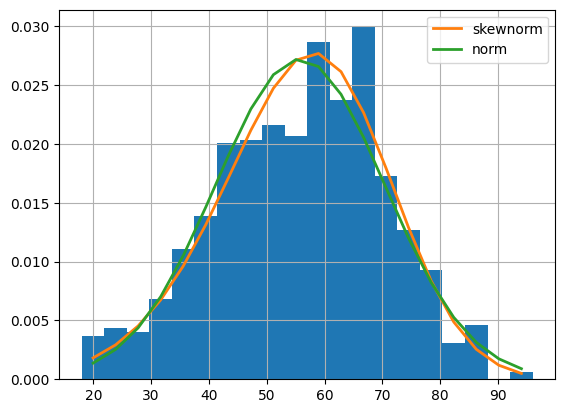

In [14]:
# After dropping all rows with "any" missing values:
f = Fitter(df_mammo.dropna()["age"], distributions=["skewnorm", "norm"], bins=20)
f.fit()
f.summary()

**After these analyses, I will go ahead and assume that the nature of the columns will not change if I drop 14% of the data. Hence, I will continue with dropping all of the rows with any missing values.**

In [15]:
df_mammo = df_mammo.dropna().reset_index(drop=True)
df_mammo

age  shape  margin  density  severity
0    67.0    3.0     5.0      3.0         1
1    58.0    4.0     5.0      3.0         1
2    28.0    1.0     1.0      3.0         0
3    57.0    1.0     5.0      3.0         1
4    76.0    1.0     4.0      3.0         1
..    ...    ...     ...      ...       ...
826  47.0    2.0     1.0      3.0         0
827  56.0    4.0     5.0      3.0         1
828  64.0    4.0     5.0      3.0         0
829  66.0    4.0     5.0      3.0         1
830  62.0    3.0     3.0      3.0         0

[831 rows x 5 columns]

# Data Preparation: Handling Outliers

Since age is the only quantitative data, I will be performing outlier detection only on that column. Additionally, since it follows a Normal Distribution (based on the p-value of KS-Test being higher than 0.05), I will be applying 3σ control limit logic to detect outliers.

In [16]:
mean = df_mammo["age"].mean()
stdev = df_mammo["age"].std()
ucl = mean + 3*stdev
lcl = mean - 3*stdev
df_mammo[(df_mammo["age"] < lcl) | (df_mammo["age"] > ucl)]

Empty DataFrame
Columns: [age, shape, margin, density, severity]
Index: []

As you may observe, there is no maximum/minimum-based outlier in the data. It is also possible to implement local outlier factor, DBSCAN or isolation forest algorithms, but at this stage I think that they would be overkill.

# Data Preparation: Normalizing the Data

There is no harm in normalizing the quantitative features so below I will be normalizing the age column.

In [17]:
scaler = StandardScaler()
df_mammo["age"] = scaler.fit_transform(df_mammo[["age"]])
df_mammo

age  shape  margin  density  severity
0    0.765804    3.0     5.0      3.0         1
1    0.151666    4.0     5.0      3.0         1
2   -1.895458    1.0     1.0      3.0         0
3    0.083429    1.0     5.0      3.0         1
4    1.379941    1.0     4.0      3.0         1
..        ...    ...     ...      ...       ...
826 -0.598946    2.0     1.0      3.0         0
827  0.015191    4.0     5.0      3.0         1
828  0.561091    4.0     5.0      3.0         0
829  0.697566    4.0     5.0      3.0         1
830  0.424616    3.0     3.0      3.0         0

[831 rows x 5 columns]

# Feature Subset Selection

In [18]:
X = df_mammo.drop("severity", axis=1)
y = df_mammo["severity"]

**Based on Information Gain:**

In [19]:
info_gain = mutual_info_classif(X, y)
df_info_gain = pd.DataFrame({"Feature": X.columns,
                             "Info Gain": info_gain}).sort_values(by="Info Gain",
                                                                  ascending=False)
display(df_info_gain)

Feature  Info Gain
2   margin   0.201179
1    shape   0.179685
0      age   0.105382
3  density   0.004097

In [20]:
tree = DecisionTreeClassifier(criterion="gini")
tree.fit(X, y)
gini_importance = tree.feature_importances_
df_gini = pd.DataFrame({"Feature": X.columns,
                        "Gini Importance": gini_importance}).sort_values(by="Gini Importance",
                                                                         ascending=False)
display(df_gini)

Feature  Gini Importance
2   margin         0.526279
0      age         0.320772
1    shape         0.099014
3  density         0.053935

**Based on Correlation:**

In [21]:
# Compute correlation:
correlation = X.corrwith(y)
df_corr = pd.DataFrame({"Feature": X.columns,
                        "Correlation": correlation}).sort_values(by="Correlation",
                                                                 ascending=False)
display(df_corr)

Feature  Correlation
margin    margin     0.573088
shape      shape     0.562970
age          age     0.455240
density  density     0.068328

**Based on Relief:**

In [22]:
# Relief-F
relief = ReliefF(n_neighbors=50)
relief.fit(X.values, y)
relief_scores = relief.feature_importances_
df_relief = pd.DataFrame({"Feature": X.columns,
                          "Relief-F Score": relief_scores}).sort_values(by="Relief-F Score",
                                                                        ascending=False)
display(df_relief)

Feature  Relief-F Score
0      age        0.183576
2   margin        0.181925
1    shape        0.125752
3  density        0.017497

**Ranking and Selecting Features**:

In [23]:
top_k = 3
top_features = {
    "Info Gain": df_info_gain["Feature"].head(top_k).values,
    "Gini": df_gini["Feature"].head(top_k).values,
    "Correlation": df_corr["Feature"].head(top_k).values,
    "Relief-F": df_relief["Feature"].head(top_k).values,
}
display(pd.DataFrame(top_features))

Info Gain    Gini Correlation Relief-F
0    margin  margin      margin      age
1     shape     age       shape   margin
2       age   shape         age    shape

**Well, it seems like there is a fact no matter what feature subset selection algorihtm you choose: the "density" column is pretty much useless.**

**One Last Test --> Brute-Force Subset Selection with kNN:**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
best_accuracy = 0
best_combination = []

# Loop through all combinations of 1, 2, 3, or 4 features:
for n in range(1, 10):
  for k in range(1, 5):
      for features in itertools.combinations(X.columns, k):
          # Select the features for this combination
          X_train_selected = X_train[list(features)]
          X_test_selected = X_test[list(features)]

          # Train kNN classifier
          knn = KNeighborsClassifier(n_neighbors=n)
          knn.fit(X_train_selected, y_train)

          # Make predictions and evaluate accuracy
          y_pred = knn.predict(X_test_selected)
          accuracy = accuracy_score(y_test, y_pred)

          # Check if this combination is the best one
          if accuracy > best_accuracy:
              best_accuracy = accuracy
              best_combination = features

# Output the best result
print(f"Best feature combination: {best_combination}")
print(f"Best accuracy: {best_accuracy}")

Best feature combination: ('age', 'shape', 'margin', 'density')
Best accuracy: 0.8203592814371258


**Well, this one is a bit unexpected. All of the Gini Index, Information Gain, Relief and Correlation methods were pretty much agreed upon density being nearly useless. However, in the case of kNN with k=5, the best combination included density. To further test the contribution of density, I will try kNN without density.**

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
best_n = 0
best_accuracy = 0
best_combination = []

# Loop through all combinations of 1, 2, 3, or 4 features:
for n in range(1, 20):
  for k in range(1, 5):
      for features in itertools.combinations(X.columns, k):
          # Select the features for this combination
          try:
            X_train_selected = X_train[list(features)].drop("density", axis=1)
            X_test_selected = X_test[list(features)].drop("density", axis=1)
            knn = KNeighborsClassifier(n_neighbors=n)
            knn.fit(X_train_selected, y_train)
          except:
            X_train_selected = X_train[list(features)]
            X_test_selected = X_test[list(features)]
          # Train kNN classifier
          knn = KNeighborsClassifier(n_neighbors=n)
          knn.fit(X_train_selected, y_train)

          # Make predictions and evaluate accuracy
          y_pred = knn.predict(X_test_selected)
          accuracy = accuracy_score(y_test, y_pred)

          # Check if this combination is the best one
          if accuracy > best_accuracy:
              best_accuracy = accuracy
              best_combination = features
              best_n = n

# Output the best result
print(f"Best feature combination: {best_combination}")
print(f"Best accuracy: {best_accuracy}")
print(f"Best n: {best_n}")

Best feature combination: ('shape', 'margin')
Best accuracy: 0.7904191616766467
Best n: 3


Well, it seems like the contribution of both age and density to the accuracy was negligible.

**Result:**

In [26]:
# Analyzing them altogether:
top_k = 2
top_features = {
    "Info Gain": df_info_gain["Feature"].head(top_k).values,
    "Gini": df_gini["Feature"].head(top_k).values,
    "Correlation": df_corr["Feature"].head(top_k).values,
    "Relief-F": df_relief["Feature"].head(top_k).values,
    "kNN":["shape", "margin"]
}
display(pd.DataFrame(top_features))

Info Gain    Gini Correlation Relief-F     kNN
0    margin  margin      margin      age   shape
1     shape     age       shape   margin  margin

In [27]:
# Creating the Analysis vs. Attributes Table:
table = pd.DataFrame({
    "margin":[1],
    "age":[1],
    "shape":[1],
    "density":[0]
})
display(table)

margin  age  shape  density
0       1    1      1        0

The most important feature is assumed to be margin and the least important feature is assumed to be density. I will use "margin", "age", "shape" as of now.

In [28]:
df_mammo = df_mammo.drop("density", axis=1)
df_mammo

age  shape  margin  severity
0    0.765804    3.0     5.0         1
1    0.151666    4.0     5.0         1
2   -1.895458    1.0     1.0         0
3    0.083429    1.0     5.0         1
4    1.379941    1.0     4.0         1
..        ...    ...     ...       ...
826 -0.598946    2.0     1.0         0
827  0.015191    4.0     5.0         1
828  0.561091    4.0     5.0         0
829  0.697566    4.0     5.0         1
830  0.424616    3.0     3.0         0

[831 rows x 4 columns]

# Predictive Analysis:

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

In [30]:
# Train-test split:
X = df_mammo.drop("severity", axis=1)
y = df_mammo["severity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Defining the classifiers:
classifiers = {
    'kNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boost': GradientBoostingClassifier(),
    # SVC with probability=True to calculate AUC:
    'SVM': SVC(probability=True),
    'Logistic Regression': LogisticRegression()
}

In [32]:
# Defining parameter grid for hyperparameter tuning:
param_grid = {
    'kNN': {
        'n_neighbors': [1, 3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    },
    'Gradient Boost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 5, 7]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'Logistic Regression': {
    'C': [0.1, 1, 10],
    'penalty': [None, 'l2', 'elasticnet'],
    'solver': ['lbfgs', 'saga']
    }
}

In [33]:
# Function for hyperparameter tuning
def tune_hyperparameters(clf, param_grid, X_train, y_train):
    grid_search = GridSearchCV(clf, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_
    best_params = grid_search.best_params_
    return best_clf, best_params

In [34]:
# Hyperparameter tuning
for name, clf in classifiers.items():
    print(f"Tuning {name}...")

    # Skip tuning for Naive Bayes as it doesn't require hyperparameter optimization
    if name == 'Naive Bayes':
        best_clf = clf
        best_params = clf.get_params()
    else:
        best_clf, best_params = tune_hyperparameters(clf, param_grid[name], X_train, y_train)

    print(f"Best Parameters for {name}: {best_params}")

    # Explicitly fit the best model for Naive Bayes and other classifiers before evaluating
    best_clf.fit(X_train, y_train)

    # Evaluate the best model on the test set
    y_pred = best_clf.predict(X_test)

    # For AUC, we need the probabilities
    if hasattr(best_clf, 'predict_proba'):
        y_prob = best_clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    else:
      # If the classifier doesn't support probability predictions
        auc = 'N/A'

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)  # F1-Score
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")  # Print F1-Score
    print(f"AUC: {auc}")
    print(f"Confusion Matrix:\n{cm}")
    print("\n")

Tuning kNN...
Best Parameters for kNN: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
Accuracy: 0.7844311377245509
Precision: 0.7553191489361702
Recall: 0.8452380952380952
F1-Score: 0.797752808988764
AUC: 0.8203528399311533
Confusion Matrix:
[[60 23]
 [13 71]]


Tuning Naive Bayes...
Best Parameters for Naive Bayes: {'priors': None, 'var_smoothing': 1e-09}
Accuracy: 0.7664670658682635
Precision: 0.7272727272727273
Recall: 0.8571428571428571
F1-Score: 0.7868852459016393
AUC: 0.8539156626506024
Confusion Matrix:
[[56 27]
 [12 72]]


Tuning Decision Tree...
Best Parameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy: 0.7664670658682635
Precision: 0.7368421052631579
Recall: 0.8333333333333334
F1-Score: 0.7821229050279329
AUC: 0.8159064830751579
Confusion Matrix:
[[58 25]
 [14 70]]


Tuning Random Forest...
Best Parameters for Random Forest: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n

**Final Remark**: Never in my life has random forest ever let me down in any project 🌲.